Data Preprocessing

In [1]:
from google.colab import files
uploaded = files.upload()

Saving PD_Class_yolov8.v2i.clip.zip to PD_Class_yolov8.v2i.clip.zip


In [2]:
import zipfile
import io

zip_file_name = 'PD_Class_yolov8.v2i.clip.zip'

with zipfile.ZipFile(io.BytesIO(uploaded[zip_file_name]), 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import keras
import os
import cv2
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [4]:
pd_img_data = os.listdir('/content/PD_Class_yolov8.v2i.clip')
pd_img_data

['test', 'valid', 'train']

In [5]:
train_pd = "/content/PD_Class_yolov8.v2i.clip/train"
test_pd = "/content/PD_Class_yolov8.v2i.clip/test"
valid_df = "/content/PD_Class_yolov8.v2i.clip/valid"

In [6]:
print(train_pd,test_pd,valid_df)

/content/PD_Class_yolov8.v2i.clip/train /content/PD_Class_yolov8.v2i.clip/test /content/PD_Class_yolov8.v2i.clip/valid


In [7]:
x_train=[]
for folder in os.listdir(train_pd):
    sub_path=train_pd+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

In [8]:
x_test=[]
for folder in os.listdir(test_pd):
    sub_path=test_pd+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

In [9]:
x_val=[]
for folder in os.listdir(valid_df):
    sub_path=test_pd+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)

In [10]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [11]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=20,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=20,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale = 1./255,
                                 rotation_range=20,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [13]:
training_set = train_datagen.flow_from_directory(train_pd,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_pd,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(valid_df,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1120 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [14]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [15]:
training_set.class_indices
train_y.shape,test_y.shape,val_y.shape

((1120,), (320,), (160,))

Display Images

In [16]:
def show_img(image_generator, num_images=10):
    images, labels = image_generator.next()
    fig, axes = plt.subplots(1, num_images, figsize=(15,3))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.show()

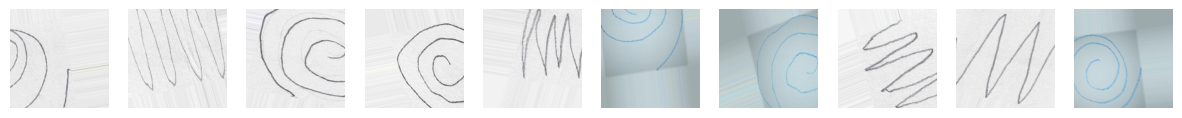

In [17]:
show_img(training_set)

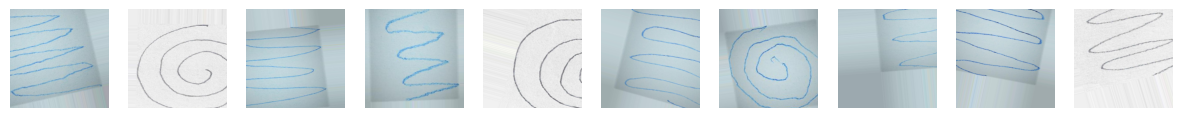

In [18]:
show_img(test_set)

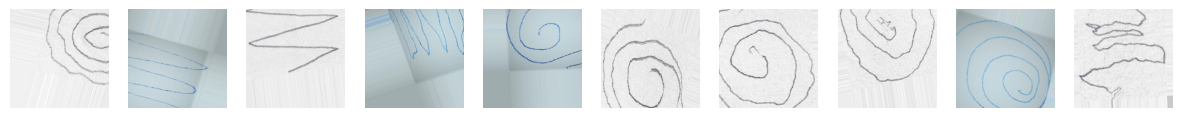

In [19]:
show_img(val_set)

Train InceptionV3

In [20]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 0s 0us/step


In [21]:
for layer in base_model.layers:
    layer.trainable = False

In [22]:
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

In [23]:
model = Model(inputs=base_model.input, outputs=output)

In [24]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(training_set, epochs=100, validation_data=val_set)

Epoch 1/100
35/35 [==============================] - 30s 555ms/step - loss: 1.2880 - accuracy: 0.6277 - val_loss: 0.5690 - val_accuracy: 0.7625
Epoch 2/100
35/35 [==============================] - 19s 538ms/step - loss: 0.5680 - accuracy: 0.7009 - val_loss: 0.4747 - val_accuracy: 0.7875
Epoch 3/100
35/35 [==============================] - 18s 518ms/step - loss: 0.5268 - accuracy: 0.7563 - val_loss: 0.5093 - val_accuracy: 0.7812
Epoch 4/100
35/35 [==============================] - 19s 540ms/step - loss: 0.5068 - accuracy: 0.7527 - val_loss: 0.5425 - val_accuracy: 0.6875
Epoch 5/100
35/35 [==============================] - 18s 523ms/step - loss: 0.4892 - accuracy: 0.7679 - val_loss: 0.5080 - val_accuracy: 0.7437
Epoch 6/100
35/35 [==============================] - 19s 542ms/step - loss: 0.5087 - accuracy: 0.7491 - val_loss: 0.5696 - val_accuracy: 0.7563
Epoch 7/100
35/35 [==============================] - 19s 541ms/step - loss: 0.4917 - accuracy: 0.7670 - val_loss: 0.4832 - val_accuracy:

In [26]:
test_eval = model.evaluate(test_set)

10/10 [==============================] - 5s 516ms/step - loss: 0.4266 - accuracy: 0.7844


In [27]:
training_accuracy = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {training_accuracy * 100:.2f}%")
print(f"Test Loss: {test_eval[0]:.4f}")
print(f"Test Accuracy: {test_eval[1] * 100:.2f}%")

Final Training Accuracy: 84.82%
Test Loss: 0.4266
Test Accuracy: 78.44%


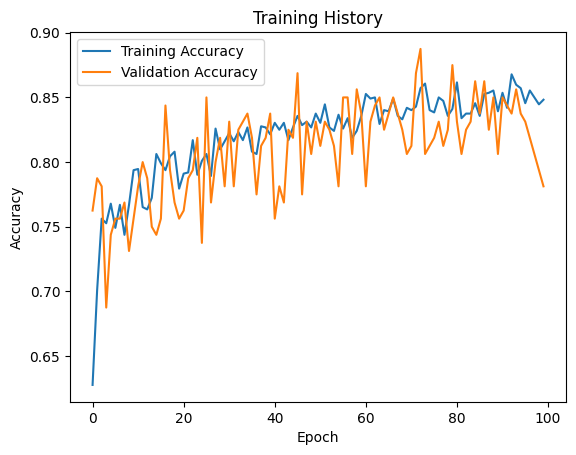

In [28]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.legend()
plt.show()

In [29]:
predictions = model.predict(test_set)
y_pred = (predictions > 0.5).astype(int).flatten()

10/10 [==============================] - 6s 482ms/step


In [30]:
y_true = test_set.classes

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [32]:
accuracy = accuracy_score(y_true, y_pred)

In [33]:
precision = precision_score(y_true, y_pred)

In [34]:
recall = recall_score(y_true, y_pred)

In [35]:
f1 = f1_score(y_true, y_pred)

In [36]:
print("Accuracy:",accuracy)
print("Precision:",precision)
print("Recall:",recall)
print("F1 Score:",f1)

Accuracy: 0.509375
Precision: 0.5099337748344371
Recall: 0.48125
F1 Score: 0.49517684887459806


In [37]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[86 74]
 [83 77]]


In [38]:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.54      0.52       160
           1       0.51      0.48      0.50       160

    accuracy                           0.51       320
   macro avg       0.51      0.51      0.51       320
weighted avg       0.51      0.51      0.51       320



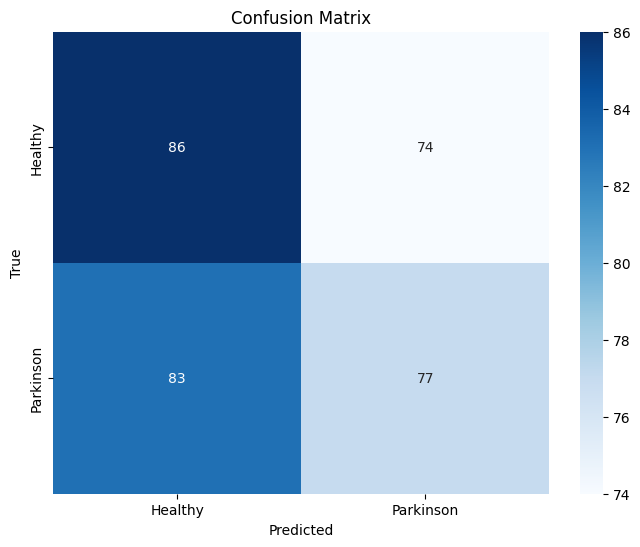

In [39]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Parkinson'], yticklabels=['Healthy', 'Parkinson'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()